[대회 링크](https://dacon.io/competitions/official/229611/codeshare/605?page=1&dtype=recent)

[참고 블로그 1](https://blog.naver.com/charzim0611)


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Load

In [97]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id') 
print(f'train : {train.shape}')
display(train.head(2))
print(f'test : {test.shape}')
display(test.head(2))


train : (210457, 13)


,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
id,,,,,,,,,,,,,
0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36


test : (91774, 12)


,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
id,,,,,,,,,,,,
210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624


In [98]:
# target 확인
set(train.columns) - set(test.columns)

{'next_arrive_time'}

In [99]:
label_name = 'next_arrive_time'
label_name

'next_arrive_time'

# Data Cleansing & Preprocessing 

### 중복되는 컬럼 제거

In [100]:
# 버스 노선
print(train[['route_id', 'route_nm']].nunique())
print()
print(train[['route_id', 'route_nm']].dtypes)

route_id    21
route_nm    21
dtype: int64

route_id     int64
route_nm    object
dtype: object


In [101]:
# station 명은 중복되니 제거
train = train.drop(columns=['route_nm'])
test = test.drop(columns=['route_nm'])
print(f'train : {train.shape}, test : {test.shape}')

train : (210457, 12), test : (91774, 11)


### 데이터 확인

In [102]:
def check_variable(dataframe):
    variable_df = pd.DataFrame({'variable': dataframe.columns,
                               'nunique': [dataframe[i].nunique() for i in dataframe.columns],
                               'dtypes': [dataframe[i].dtypes for i in dataframe.columns],
                               'NaN': [dataframe[i].isna().sum() for i in dataframe.columns],
                               'count': [dataframe[i].count() for i in dataframe.columns],})

    variable_df = variable_df.sort_values('nunique', ascending=False)
    variable_df = variable_df.reset_index(drop = True)
    return variable_df

display(check_variable(train))
display(check_variable(test))

,variable,nunique,dtypes,NaN,count
0,next_arrive_time,596,int64,0,210457
1,next_longitude,569,float64,0,210457
2,now_longitude,567,float64,0,210457
3,next_latitude,564,float64,0,210457
4,now_latitude,562,float64,0,210457
5,distance,414,float64,0,210457
6,next_station,351,object,0,210457
7,now_station,348,object,0,210457
8,vh_id,104,int64,0,210457
9,route_id,21,int64,0,210457


,variable,nunique,dtypes,NaN,count
0,now_longitude,567,float64,0,91774
1,next_longitude,566,float64,0,91774
2,now_latitude,562,float64,0,91774
3,next_latitude,561,float64,0,91774
4,distance,413,float64,0,91774
5,next_station,350,object,0,91774
6,now_station,349,object,0,91774
7,vh_id,100,int64,0,91774
8,route_id,21,int64,0,91774
9,now_arrive_time,19,object,0,91774


In [103]:
# train['now_arrive_time'] = train['now_arrive_time'].map(lambda x: int(x.replace('시', '')))
# test['now_arrive_time'] = test['now_arrive_time'].map(lambda x: int(x.replace('시', '')))
# display(check_variable(train))
# display(check_variable(test))

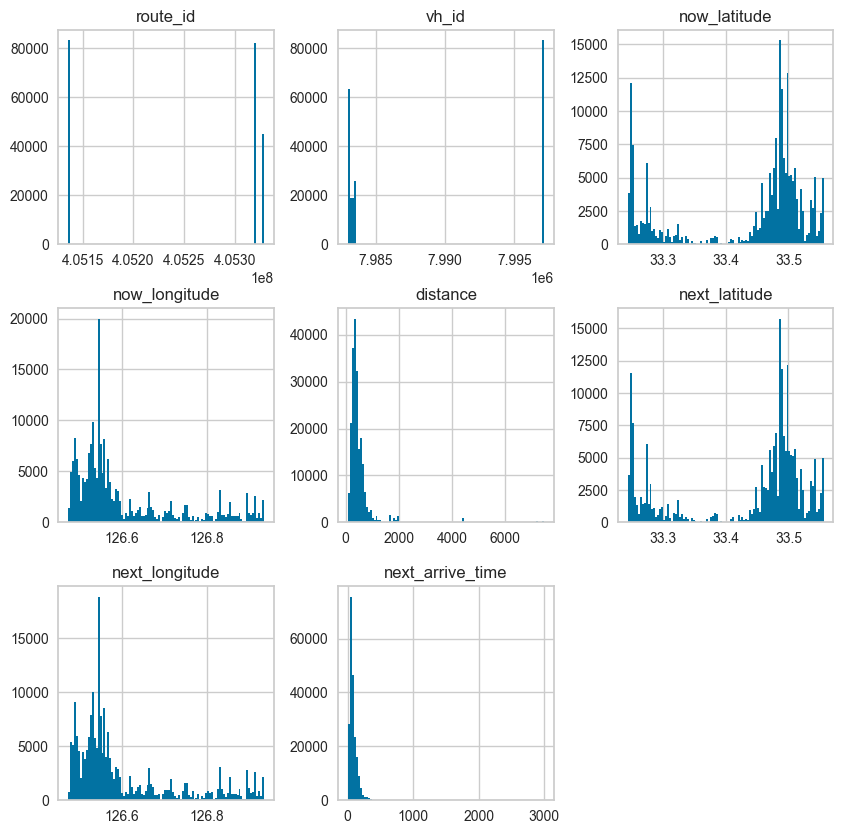

In [104]:
# 로그 변환과 스케일링이 도움이 될 수도?
# vh_id가 글쎄...?
train.hist(bins=100, figsize=(10, 10));

### 데이터 타입 변환

In [105]:
# https://blog.doosikbae.com/89
# 요일 변환
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.day_name()

train['weekday'].value_counts()


Tuesday      31311
Thursday     30968
Wednesday    30818
Monday       30353
Friday       30003
Saturday     28806
Sunday       28198
Name: weekday, dtype: int64

In [106]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.day_name()
test['weekday'].value_counts()

Tuesday      26435
Friday       13541
Monday       13503
Sunday       12609
Saturday     10845
Thursday     10182
Wednesday     4659
Name: weekday, dtype: int64

In [107]:
# now_arrive_time
train['now_arrive_time'] = train['now_arrive_time'].map(lambda x : int(x.replace('시', '')))
test['now_arrive_time'] = test['now_arrive_time'].map(lambda x : int(x.replace('시', '')))

### 정류장 라벨인코딩(선후관계)

In [108]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

all_station = list(train['now_station'].values) + list(train['next_station'].values)
station_set = set(all_station)
print(len(station_set))
le.fit(list(station_set))

train['now_station'] = le.transform(train['now_station'])
train['next_station'] = le.transform(train['next_station'])
test['now_station'] = le.transform(test['now_station'])
test['next_station'] = le.transform(test['next_station'])
train.head()

351


,date,route_id,vh_id,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday
id,,,,,,,,,,,,,
0,2019-10-15,405136001,7997025,33.456267,126.551750,239,6,266.0,227,33.457724,126.554014,24,Tuesday
1,2019-10-15,405136001,7997025,33.457724,126.554014,227,6,333.0,228,33.458783,126.557353,36,Tuesday
2,2019-10-15,405136001,7997025,33.458783,126.557353,228,6,415.0,235,33.459893,126.561624,40,Tuesday
3,2019-10-15,405136001,7997025,33.479705,126.543811,41,6,578.0,249,33.484860,126.542928,42,Tuesday
4,2019-10-15,405136001,7997025,33.485662,126.494923,63,7,374.0,221,33.485822,126.490897,64,Tuesday


### 원핫인코딩

In [109]:
train = pd.get_dummies(train, columns=['weekday'])
test = pd.get_dummies(test, columns=['weekday'])

train.columns, test.columns

(Index(['date', 'route_id', 'vh_id', 'now_latitude', 'now_longitude',
        'now_station', 'now_arrive_time', 'distance', 'next_station',
        'next_latitude', 'next_longitude', 'next_arrive_time', 'weekday_Friday',
        'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
        'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'],
       dtype='object'),
 Index(['date', 'route_id', 'vh_id', 'now_latitude', 'now_longitude',
        'now_station', 'now_arrive_time', 'distance', 'next_station',
        'next_latitude', 'next_longitude', 'weekday_Friday', 'weekday_Monday',
        'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
        'weekday_Tuesday', 'weekday_Wednesday'],
       dtype='object'))

### 이상치 제거

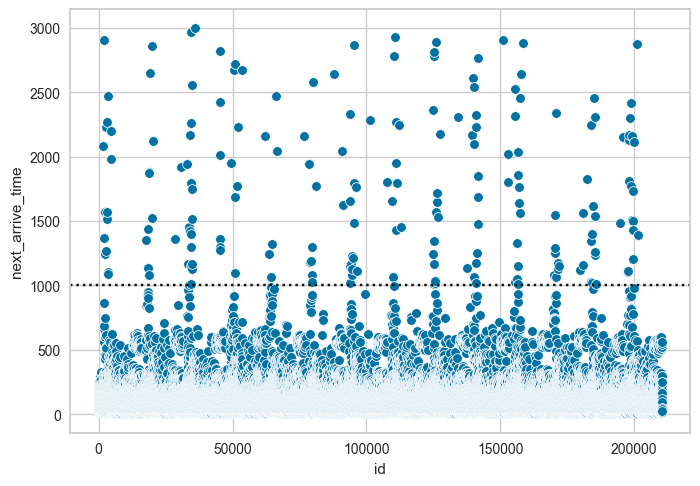

In [110]:
sns.scatterplot(data=train, x=train.index, y="next_arrive_time")
plt.axhline(1000, c="k", ls=":")

In [111]:
train = train[train['next_arrive_time'] <= 1000]
train

,date,route_id,vh_id,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
id,,,,,,,,,,,,,,,,,,,
0,2019-10-15,405136001,7997025,33.456267,126.551750,239,6,266.0,227,33.457724,126.554014,24,0,0,0,0,0,1,0
1,2019-10-15,405136001,7997025,33.457724,126.554014,227,6,333.0,228,33.458783,126.557353,36,0,0,0,0,0,1,0
2,2019-10-15,405136001,7997025,33.458783,126.557353,228,6,415.0,235,33.459893,126.561624,40,0,0,0,0,0,1,0
3,2019-10-15,405136001,7997025,33.479705,126.543811,41,6,578.0,249,33.484860,126.542928,42,0,0,0,0,0,1,0
4,2019-10-15,405136001,7997025,33.485662,126.494923,63,7,374.0,221,33.485822,126.490897,64,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,2019-10-28,405328102,7983486,33.255783,126.577450,95,21,528.0,108,33.251896,126.574417,96,0,1,0,0,0,0,0
210453,2019-10-28,405328102,7983486,33.248595,126.568527,65,21,280.0,81,33.249753,126.565959,50,0,1,0,0,0,0,0
210454,2019-10-28,405328102,7983486,33.251891,126.560303,122,21,114.0,178,33.251084,126.559551,16,0,1,0,0,0,0,0


In [112]:
display(check_variable(train))
display(check_variable(test))

,variable,nunique,dtypes,NaN,count
0,next_longitude,568,float64,0,210257
1,now_longitude,567,float64,0,210257
2,next_latitude,563,float64,0,210257
3,now_latitude,562,float64,0,210257
4,next_arrive_time,422,int64,0,210257
5,distance,414,float64,0,210257
6,next_station,350,int32,0,210257
7,now_station,348,int32,0,210257
8,vh_id,104,int64,0,210257
9,route_id,21,int64,0,210257


,variable,nunique,dtypes,NaN,count
0,now_longitude,567,float64,0,91774
1,next_longitude,566,float64,0,91774
2,now_latitude,562,float64,0,91774
3,next_latitude,561,float64,0,91774
4,distance,413,float64,0,91774
5,next_station,350,int32,0,91774
6,now_station,349,int32,0,91774
7,vh_id,100,int64,0,91774
8,route_id,21,int64,0,91774
9,now_arrive_time,19,int64,0,91774


# Pycaret

In [50]:
from pycaret.regression import *
exp_reg101 = setup(data = train, 
                   target = label_name,
                   ignore_features = ['date'], 
                   session_id=123)

,Description,Value
0,session_id,123
1,Target,next_arrive_time
2,Original Data,"(210257, 19)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(147179, 54)"


In [51]:
best_model = compare_models(sort ='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,20.2752,1088.4365,32.9802,0.7450,0.3268,0.2797,13.4860
catboost,CatBoost Regressor,20.4330,1089.9276,33.0042,0.7446,0.3283,0.2828,12.4400
rf,Random Forest Regressor,20.4394,1194.0569,34.5467,0.7201,0.3356,0.2767,55.5200
lightgbm,Light Gradient Boosting Machine,21.3938,1149.4651,33.8928,0.7307,0.3414,0.3015,0.6890
knn,K Neighbors Regressor,21.5284,1303.8988,36.0965,0.6945,0.3502,0.2917,1.4730
et,Extra Trees Regressor,22.6333,1572.1114,39.6441,0.6316,0.3771,0.3019,82.0700
gbr,Gradient Boosting Regressor,25.8526,1501.0876,38.7336,0.6483,0.4027,0.3792,13.4300
dt,Decision Tree Regressor,25.5424,2016.2702,44.8939,0.5276,0.4317,0.3393,1.1900
br,Bayesian Ridge,33.6665,2576.0786,50.7485,0.3966,0.5155,0.5130,0.9410
lr,Linear Regression,33.6697,2576.0801,50.7485,0.3966,0.5156,0.5130,3.0210


# 모델 생성

### pycaret Top 3

In [52]:
# Top 3 모델 선정, compare_models 에서 이미 cv를 했으므로 False로 설정

xgb = create_model('xgboost', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20.5835,1171.7316,34.2306,0.7331,0.3291,0.2808


In [54]:
catb = create_model('catboost', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20.7523,1172.155,34.2367,0.733,0.3302,0.2838


In [53]:
rf = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20.8069,1291.5886,35.9387,0.7058,0.3388,0.2782


In [26]:
# # 파라미터 튜닝 = > 300분이 소요되도 실패!
# tuned_xgb = tune_model(top1, optimize = 'RMSLE', n_iter = 10)
# tuned_rf = tune_model(top2, optimize = 'RMSLE', n_iter = 10)
# tuned_catb = tune_model(top3, optimize = 'RMSLE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23.1163,3782.9516,61.5057,0.4936,0.3666,0.3071
1,22.5094,2580.9661,50.8032,0.5299,0.3658,0.3184
2,23.6577,4797.6883,69.2653,0.4075,0.3663,0.3128
3,23.0211,3600.0427,60.0004,0.4411,0.3677,0.3146
4,23.2377,4279.3284,65.4166,0.4319,0.3733,0.3098
5,23.1541,3843.6465,61.9971,0.5026,0.3619,0.3099
6,22.8593,3383.0161,58.1637,0.5134,0.3646,0.3120
7,22.9623,3813.8412,61.7563,0.5486,0.3602,0.3085
8,23.2609,3399.8073,58.3079,0.5235,0.3691,0.3172


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:13:07
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.3min


: 

## Randomforest - RandomizedSearchCV

### 피처선별

In [115]:
feature_names = train.columns.tolist()
feature_names.remove(label_name)
feature_names.remove('date')

# 경도 위도와 중복되므로 제거 
feature_names.remove('now_latitude')
feature_names.remove('now_longitude')
feature_names.remove('next_latitude')
feature_names.remove('next_longitude')

check_variable(train[feature_names])

,variable,nunique,dtypes,NaN,count
0,distance,414,float64,0,210257
1,next_station,350,int32,0,210257
2,now_station,348,int32,0,210257
3,vh_id,104,int64,0,210257
4,route_id,21,int64,0,210257
5,now_arrive_time,20,int64,0,210257
6,weekday_Friday,2,uint8,0,210257
7,weekday_Monday,2,uint8,0,210257
8,weekday_Saturday,2,uint8,0,210257
9,weekday_Sunday,2,uint8,0,210257


### 데이터 분할

In [116]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head(2)

(210257, 13)


,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
id,,,,,,,,,,,,,
0,405136001,7997025,239,6,266.0,227,0,0,0,0,0,1,0
1,405136001,7997025,227,6,333.0,228,0,0,0,0,0,1,0


In [117]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head(2)

(91774, 13)


,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
id,,,,,,,,,,,,,
210457,405136001,7997025,227,7,333.0,228,0,0,0,0,0,1,0
210458,405136001,7997025,228,7,415.0,235,0,0,0,0,0,1,0


In [118]:
y_train = train[label_name]
print(y_train.shape)

(210257,)


### RandomForestRegressor

In [119]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [120]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {"max_depth": np.random.randint(10, 20, 10), 
                       "max_features": np.random.uniform(0.8, 1, 10)}

reg = RandomizedSearchCV(model, 
                         param_distributions=param_distributions, 
                         scoring="neg_mean_squared_log_error",
                         n_iter=10, cv=5, n_jobs=-1, 
                         verbose=2, random_state=42)
reg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [121]:
# (max_depth=15, max_features=0.8483619676045983, n_jobs=-1, random_state=42)
best_model = reg.best_estimator_
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features=0.8456526461757912,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

# 제출 CSV 생성

In [123]:
sub = pd.read_csv('data/submission_제출양식.csv')
print(sub.shape)
sub.head(2)

(91774, 2)


,id,next_arrive_time
0,210457,0
1,210458,0


### XGBoost
- RMSLE : 0.3291

In [129]:
y_xgb_predict = xgb.fit(X_train, y_train).predict(X_test)
sub['next_arrive_time'] = y_xgb_predict
file_name = 'data/submission_xgb.csv'

sub.to_csv(file_name, index=False)
pd.read_csv(file_name)

print(file_name)

data/submission_xgb.csv


### CatBoost
- RMSLE : 0.3302

In [130]:
y_catb_predict = catb.fit(X_train, y_train).predict(X_test)
sub['next_arrive_time'] = y_catb_predict
file_name = 'data/submission_catb.csv'

sub.to_csv(file_name, index=False)
pd.read_csv(file_name)

print(file_name)

data/submission_catb.csv


### RandomForest(pycaret)
- RMSLE : 0.3388

In [131]:
y_rf_predict = rf.fit(X_train, y_train).predict(X_test)
sub['next_arrive_time'] = y_rf_predict
file_name = 'data/submission_rf1.csv'

sub.to_csv(file_name, index=False)
pd.read_csv(file_name)

print(file_name)

data/submission_rf1.csv


### RandomForest(tuning)

In [132]:
y_best_model_predict = best_model.fit(X_train, y_train).predict(X_test)
sub['next_arrive_time'] = y_best_model_predict
file_name = 'data/submission_best_model.csv'

sub.to_csv(file_name, index=False)
pd.read_csv(file_name)

print(file_name)

data/submission_best_model.csv
